In [1]:
from pathlib import Path
import itertools
import os

import numpy as np
import matplotlib.pyplot as plt
import polars as pl

from UnifiedMomentumModel.Utilities.Other import for_each

from UnifiedMomentumModel.Momentum import UnifiedMomentum

np.seterr(all="ignore")

figdir = Path(os.getcwd()).parent / "fig"
figdir.mkdir(exist_ok=True, parents=True)

lesdir = Path(os.getcwd()) / "LES_data"

# Generate data
Grid search over $C_T'$ and $\gamma$.

In [2]:
Cts = np.concatenate([np.linspace(-7, -0.1), np.logspace(-1, 12, 100)])
yaws = [0]  

params = list(itertools.product(Cts, yaws))
unified_momentum_model = UnifiedMomentum()


def func(x):
    Ct, yaw = x
    sol = unified_momentum_model(Ct, np.deg2rad(yaw))
    a, u4, v4, dp = sol.an, sol.u4, sol.v4, sol.dp
    return dict(Ctprime=Ct, yaw=yaw, a=a, u4=u4, v4=v4, dp=-dp)


np.seterr(invalid="ignore")
out = for_each(func, params, parallel=True)
df = pl.from_dicts(out).interpolate()

/home/jaime/Repositories/Unified-Momentum-Model/UnifiedMomentumModel/Utilities/FixedPointIteration.py:56: RuntimeWarning: All-NaN slice encountered
  max_resid = [np.nanmax(np.abs(_r)) for _r in residuals]
  0%|          | 0/150 [00:00<?, ?it/s]/home/jaime/Repositories/Unified-Momentum-Model/UnifiedMomentumModel/Utilities/FixedPointIteration.py:56: RuntimeWarning: All-NaN slice encountered
  max_resid = [np.nanmax(np.abs(_r)) for _r in residuals]
/home/jaime/Repositories/Unified-Momentum-Model/UnifiedMomentumModel/Utilities/FixedPointIteration.py:56: RuntimeWarning: All-NaN slice encountered
  max_resid = [np.nanmax(np.abs(_r)) for _r in residuals]
/home/jaime/Repositories/Unified-Momentum-Model/UnifiedMomentumModel/Utilities/FixedPointIteration.py:56: RuntimeWarning: All-NaN slice encountered
  max_resid = [np.nanmax(np.abs(_r)) for _r in residuals]
100%|██████████| 150/150 [00:04<00:00, 34.80it/s] 


## Add additional columns
$C_p$, $C_T$, $x_0$, etc.

In [3]:
# Add columns (e.g. C_T, C_P)
df = df.with_columns(
    (
        pl.col("Ctprime")
        * (1 - pl.col("a")) ** 2
        * np.cos(np.deg2rad(pl.col("yaw"))) ** 2
    ).alias("Ct"),
    (
        pl.col("Ctprime") * ((1 - pl.col("a")) * np.cos(np.deg2rad(pl.col("yaw")))) ** 3
    ).alias("Cp"),
)


# Momentum theory

In [4]:
a = np.linspace(-1, 1, 1000)
Ct = 4 * a * np.abs(1 - a)

df_momentum = pl.DataFrame([Ct, a], schema=["Ct", "a"])

# Glauert

In [5]:
a = np.linspace(0.4, 1)
Ct = 0.889 - (0.0203 - (a - 0.143) ** 2) / 0.6427
df_glauert = pl.DataFrame([Ct, a], schema=["Ct", "a"])

# LES

In [6]:
les_data_files = {
    "C_T": lesdir / "ct_data_les_ct_input.txt",
    "C_Tprime": lesdir / "ct_data_les_ctp_input.txt",
    "NREL": lesdir / "ct_data_les_tony.txt",
}

dfs = []
for key, fn in les_data_files.items():
    dfs.append(
        pl.read_csv(
            fn,
            has_header=False,
            columns=[0, 1],
            new_columns=["a", "Ct"],
        ).with_columns(pl.lit(key).alias("method"))
    )

df_negative = (
    pl.read_csv(
        lesdir / "ct_data_les_ct_input_negativeCt.txt",
        has_header=False,
        separator=";",
        new_columns=["Ct", "u_d", "p4", "u4"],
    )
    .with_columns((1 - pl.col("u_d")).alias("a"), pl.lit("C_T").alias("method"))
    .select("a", "Ct", "method")
)

dfs.append(df_negative)
df_les = pl.concat(dfs).filter(pl.col("a") < 1.01)
print(df_les)

shape: (68, 3)
┌───────────┬──────┬────────┐
│ a         ┆ Ct   ┆ method │
│ ---       ┆ ---  ┆ ---    │
│ f64       ┆ f64  ┆ str    │
╞═══════════╪══════╪════════╡
│ 0.052924  ┆ 0.2  ┆ C_T    │
│ 0.112367  ┆ 0.4  ┆ C_T    │
│ 0.181635  ┆ 0.6  ┆ C_T    │
│ 0.269057  ┆ 0.8  ┆ C_T    │
│ …         ┆ …    ┆ …      │
│ -0.154475 ┆ -0.7 ┆ C_T    │
│ -0.173827 ┆ -0.8 ┆ C_T    │
│ -0.192722 ┆ -0.9 ┆ C_T    │
│ -0.211166 ┆ -1.0 ┆ C_T    │
└───────────┴──────┴────────┘


# Curved text class from stackoverflow
https://stackoverflow.com/a/44521963

In [7]:
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
import numpy as np
import math


class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    From https://stackoverflow.com/a/44521963
    """

    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0], y[0], " ", **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == " ":
                ##make this an invisible 'a':
                t = mtext.Text(0, 0, "a")
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0, 0, c, **kwargs)

            # resetting unnecessary arguments
            t.set_ha("center")
            t.set_rotation(0)
            t.set_zorder(self.__zorder + 1)

            self.__Characters.append((c, t))
            axes.add_artist(t)

    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c, t in self.__Characters:
            t.set_zorder(self.__zorder + 1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self, renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        # preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w) / (figH * h)) * (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])

        # points of the curve in figure coordinates:
        x_fig, y_fig = (
            np.array(l)
            for l in zip(
                *self.axes.transData.transform(
                    [(i, j) for i, j in zip(self.__x, self.__y)]
                )
            )
        )

        # point distances in figure coordinates
        x_fig_dist = x_fig[1:] - x_fig[:-1]
        y_fig_dist = y_fig[1:] - y_fig[:-1]
        r_fig_dist = np.sqrt(x_fig_dist**2 + y_fig_dist**2)

        # arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist), 0, 0)

        # angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]), (x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)

        rel_pos = 10
        for c, t in self.__Characters:
            # finding the width of c:
            t.set_rotation(0)
            t.set_va("center")
            bbox1 = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            # ignore all letters that don't fit:
            if rel_pos + w / 2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != " ":
                t.set_alpha(1.0)

            # finding the two data points between which the horizontal
            # center point of the character will be situated
            # left and right indices:
            il = np.where(rel_pos + w / 2 >= l_fig)[0][-1]
            ir = np.where(rel_pos + w / 2 <= l_fig)[0][0]

            # if we exactly hit a data point:
            if ir == il:
                ir += 1

            # how much of the letter width was needed to find il:
            used = l_fig[il] - rel_pos
            rel_pos = l_fig[il]

            # relative distance between il and ir where the center
            # of the character will be
            fraction = (w / 2 - used) / r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il] + fraction * (self.__x[ir] - self.__x[il])
            y = self.__y[il] + fraction * (self.__y[ir] - self.__y[il])

            # getting the offset when setting correct vertical alignment
            # in data coordinates
            t.set_va(self.get_va())
            bbox2 = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0] - bbox1d[0])

            # the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array(
                [
                    [math.cos(rad), math.sin(rad) * aspect],
                    [-math.sin(rad) / aspect, math.cos(rad)],
                ]
            )

            ##computing the offset vector of the rotated character
            drp = np.dot(dr, rot_mat)

            # setting final position and rotation:
            t.set_position(np.array([x, y]) + drp)
            t.set_rotation(degs[il])

            t.set_va("center")
            t.set_ha("center")

            # updating rel_pos to right edge of character
            rel_pos += w - used

# plot $C_T$ versus $a$


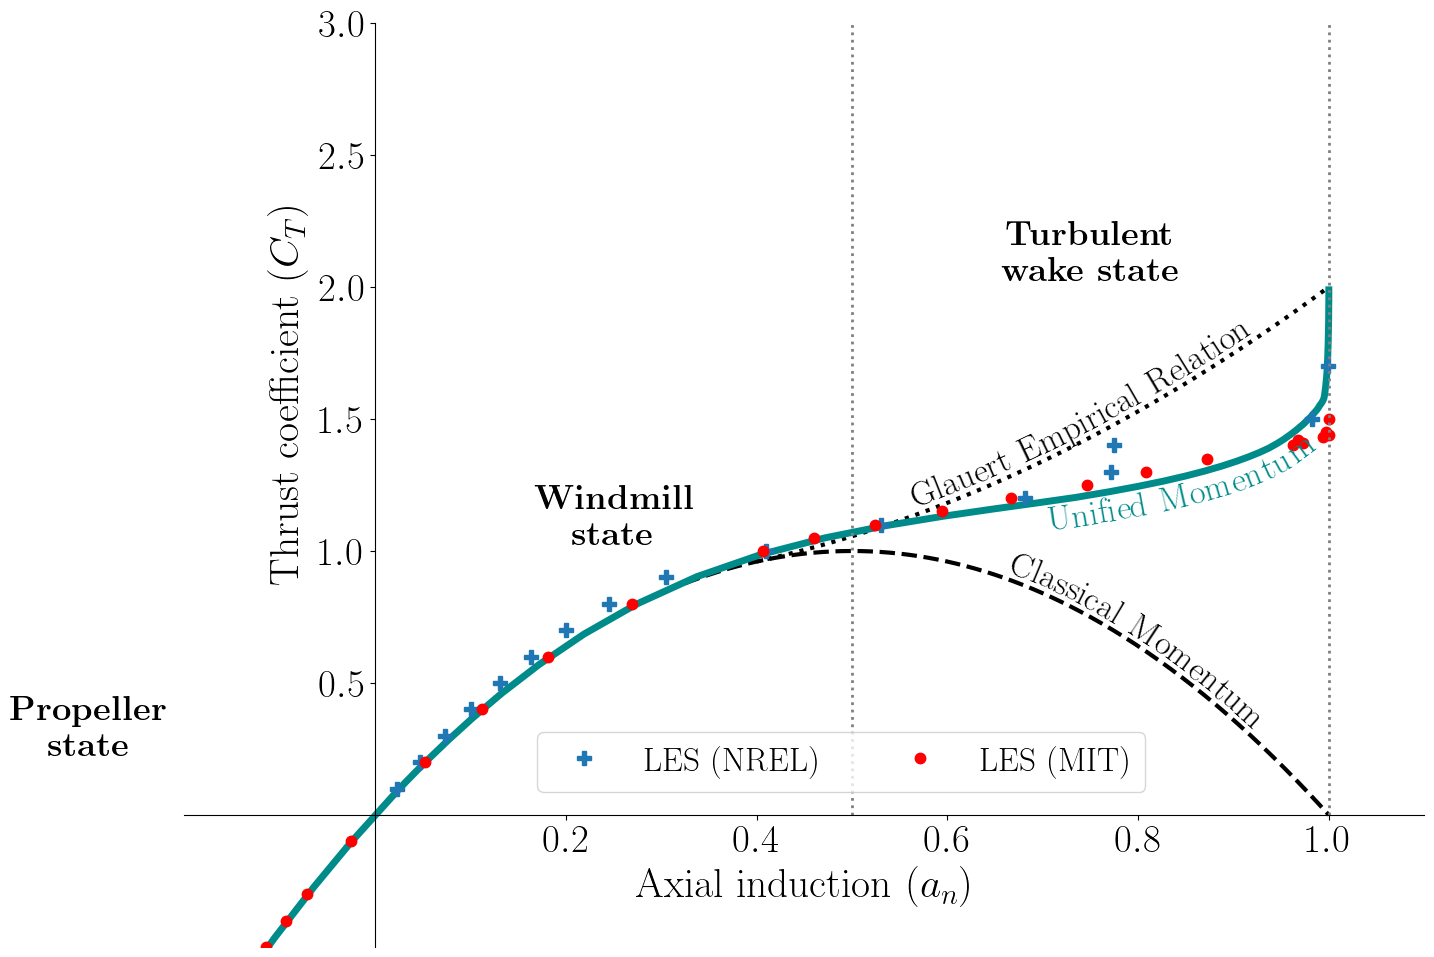

In [8]:
import matplotlib

# Use Latex Fonts
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

plt.figure(figsize=4 * np.array([4, 3]))
ax = plt.gca()

# Special green
that_funny_green = "#008b8b"

matplotlib.rcParams.update({"font.size": 20})


# Plot Classic Momentum theory
plt.plot(
    df_momentum["a"],
    df_momentum["Ct"],
    "k--",
    lw=3,
)


# Plot Glauert
plt.plot(
    df_glauert["a"],
    df_glauert["Ct"],
    "k:",
    lw=3,
)


### Plot unified momentum theory
_df = df.filter(pl.col("yaw") == 0)
# Add point at zero
a = np.concatenate([[0], _df["a"].to_numpy()])
Ct = np.concatenate([[0], _df["Ct"].to_numpy()])
plt.plot(
    a,
    Ct,
    c=that_funny_green,
    lw=5,
)


# Plot LES
les_plot_options = {
    "C_T": dict(
        marker=".",
        label="LES (MIT)",
        c="r",
        ms=15,
    ),
    "C_Tprime": dict(
        marker="D",
        label="LES ($C_T'$)",
        c="tab:orange",
        ms=8,
    ),
    "NREL": dict(
        marker="P",
        label="LES (NREL)",
        c="tab:blue",
        ms=10,
    ),
}
for key in [
    "NREL",
    "C_T",
]:
    _df = df_les.filter(pl.col("method") == key)
    plt.plot(
        _df["a"],
        _df["Ct"],
        ls="",
        alpha=1,
        **les_plot_options[key],
    )


# Plot curved text
a = df_momentum.filter(pl.col("a") > 0.65)["a"].to_numpy()
Ct = df_momentum.filter(pl.col("a") > 0.65)["Ct"].to_numpy()
CurvedText(
    a,
    Ct,
    text="Classical Momentum",
    va="bottom",
    axes=ax,
    fontsize=25,
)

a = df_glauert.filter(pl.col("a") > 0.55)["a"].to_numpy()
Ct = df_glauert.filter(pl.col("a") > 0.55)["Ct"].to_numpy()
CurvedText(
    a,
    Ct,
    text="Glauert Empirical Relation",
    va="bottom",
    axes=ax,
    fontsize=25,
)

a = df.filter(pl.col("a") > 0.65).filter(pl.col("yaw") == 0)["a"].to_numpy()
Ct = df.filter(pl.col("a") > 0.65).filter(pl.col("yaw") == 0)["Ct"].to_numpy() - 0.02
CurvedText(
    a,
    Ct,
    text="Unified Momentum",
    c=that_funny_green,
    va="top",
    axes=ax,
    fontsize=25,
)

# State labels
state_params = dict(va="bottom", ha="center", weight="bold", fontsize=25)
state_params2 = dict(va="bottom", ha="center", weight="bold", fontsize=25)
plt.text(-0.3, 0.2, r"\textbf{Propeller}" "\n" r"\textbf{state}", **state_params)
plt.text(0.25, 1, r"\textbf{Windmill}" "\n" r"\textbf{state}", **state_params)
plt.text(0.75, 2.0, r"\textbf{Turbulent}" "\n" r"\textbf{wake state}", **state_params)

# Vertical lines
vline_settings = dict(lw=2, colors="0.5", ls=":", ymin=0, ymax=4)
plt.vlines(0.5, **vline_settings)
plt.vlines(1, **vline_settings)

# Axis labels and limits
plt.xlabel("Axial induction $(a_n)$", fontsize=30)
plt.ylabel("Thrust coefficient $(C_T)$", fontsize=30)
ax.yaxis.set_label_coords(0.1, 0.6)

plt.xlim(-0.2, 1.1)
plt.ylim(-0.5, 3.0)

# x and y ticks
plt.xticks(np.arange(0.2, 1.01, 0.2))
plt.yticks(np.arange(0.5, 3.1, 0.5))

plt.tick_params(axis="both", which="both", labelsize=28)

# Remove top and right frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# move axis origin to (0, 0)
ax.spines["left"].set_position("zero")
ax.spines["bottom"].set_position("zero")

# legend
plt.legend(bbox_to_anchor=[0.53, 0.15], loc="lower center", ncol=3, fontsize="large")
plt.savefig(figdir / "Figure1_axis_3_state.png", dpi=500, bbox_inches="tight")